In [1]:
import os
import pathlib

import numpy as np
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

/home/pi/.local/lib/python3.7/site-packages/h5py/__init__.py:40: UserWarning: h5py is running against HDF5 1.10.6 when it was built against 1.10.4, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)


In [2]:
from scipy import signal
import matplotlib.pyplot as plt

def get_melcepstrum(spectrogram):
    #1.频率转梅尔频率
    #2.梅尔频率下，滤波器线性排列n个滤波器
    #3.把滤波器梅尔频率转回频率，得到的滤波器三角形底边长就是逐渐增长的
    #4.得到离散的三角形
    #5.将每个离散的三角形滤波器*频谱图，得到梅尔频谱
    #PS: 无论傅里叶变化得到的频谱图还是梅尔频谱，w轴本质都是个尺度问题。频谱图有自己的尺度，梅尔频谱有自己的尺度。
    #每个滤波器三角形是重叠1/2的，这意味着，当我们在[0,513]设置40个距离相等的梅尔频率点时，我们得到了80个可选的三角形滤波器。
    #但是由于我们只需要40个。所以我们从左到右选择40个。
    #这40个三角形滤波器的频率范围为0-1848Hz。当滤波器数量为80个时，频率范围与上相同，但是滤波器
    #更加密集。每个滤波器代表的频率范围更小。
    #参数作用 当最低频率为0 最高频率(不能超过采样率/2)为8000Hz时
    #滤波器数量越多，被选中的范围也越大
    #当滤波器数量为40时，被提取的频率点范围为0-1848Hz 接近人耳听力范围
    #当滤波器数量不变，被选中的范围缩小时，被提取的频率点范围缩小
    low_freq_mel = 0 #低频点hz
    high_freq_mel = 512 #高频点hz（当对于STFT来说，0-8000Hz 对应着0-513个频率点
    high_freq_mel = (2595 * np.log10(1 + high_freq_mel / 700)) #根据公式将频率转换为梅尔频率
    nfilter = 40 #梅尔滤波器数量
    hz_points = np.array([])#梅尔滤波器三角形 左端点 中间点 右端点
    hz_points_center  = np.array([])#每个梅尔滤波器中间点坐标
    mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilter+1) #生成距离相等的梅尔频率点

    # 将生成的梅尔频率转换成频率点
    hz_points_1 = (700 * (10**(mel_points / 2595) - 1)) #不含中间点
    for i in range(0,int(hz_points_1.shape[0]-1)):
        hz_points_center = np.append(hz_points_center, np.floor((hz_points_1[i]+hz_points_1[i+1])/2))
        

    hz_points = np.append(hz_points,np.floor(hz_points_1))
    hz_points = np.append(hz_points,hz_points_center)
    hz_points = np.sort(hz_points) #所有滤波器三角形坐标(左端坐标，中间坐标，右端坐标)由小到大排列

    mel_filter = np.zeros([nfilter, 513])#存储滤波器的系数

    for n_mel_filter in range(1, nfilter + 1): #以中心坐标标记滤波器，第一个滤波器中心坐标1，第二个滤波器中心坐标3...
        mel_filter_left = int(hz_points[n_mel_filter - 1])   # 一个滤波器左端坐标
        mel_filter_center = int(hz_points[n_mel_filter])             # 一个滤波器中心坐标
        mel_filter_right = int(hz_points[n_mel_filter + 1])    # 一个滤波器右端坐标
        for k in range(mel_filter_left, mel_filter_center): #计算每个滤波器的系数 
            mel_filter[n_mel_filter - 1, k] = (k - hz_points[n_mel_filter - 1]) / (hz_points[n_mel_filter] - hz_points[n_mel_filter - 1])
        for k in range(mel_filter_center, mel_filter_right):
            mel_filter[n_mel_filter - 1, k] = (hz_points[n_mel_filter + 1] - k) / (hz_points[n_mel_filter + 1] - hz_points[n_mel_filter])

    #依次将每个T时刻的频谱转换为梅尔频谱，并拼接
    for i,spectrogram_1t in enumerate(tf.squeeze(spectrogram, axis=-1).numpy().T):
        melcepstrum = np.dot(spectrogram_1t, mel_filter.T)
        melcepstrum = np.where(melcepstrum == 0, np.finfo(float).eps, melcepstrum)  # Numerical Stability
        melcepstrum = 20 * np.log10(melcepstrum)  # dB
        melcepstrum = melcepstrum[:,np.newaxis]
        if i == 0:
            melcepstrum_ = melcepstrum
        else:
            melcepstrum_ = np.append(melcepstrum_,melcepstrum,axis=1)
    melcepstrum_tf = tf.convert_to_tensor(melcepstrum_.T)
    melcepstrum_tf = melcepstrum_tf[..., tf.newaxis]# 新增一个aixs
    
    plt.figure()
    plt.imshow(tf.math.log(tf.squeeze(melcepstrum_tf, axis=-1)).numpy())
    
    return melcepstrum_tf
        
def get_spectrogram(waveform):
  # Zero-padding for an audio waveform with less than 16,000 samples.
  input_len = 16000
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
      [16000] - tf.shape(waveform),
      dtype=tf.float32)
  # Cast the waveform tensors' dtype to float32.
  waveform = tf.cast(waveform, dtype=tf.float32)
  # Concatenate the waveform with `zero_padding`, which ensures all audio
  # clips are of the same length.
  equal_length = tf.concat([waveform, zero_padding], 0)
  # Convert the waveform to a spectrogram via a STFT.
  #f频率数组，时间数组，STFT结果
  equal_length_np = equal_length.numpy()
  [f,t,spectrogram]=signal.spectral.spectrogram(equal_length.numpy(),nperseg=513,nfft=1024,detrend=False)
  #spectrogram = tf.signal.stft(
  #    equal_length, frame_length=1024, frame_step=512)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  # Batch Size，样本数（时间序列长度/frame_step=125），频率点数(样本窗口/2)，通道
    #显示波形和频谱
  spectrogram = spectrogram[:,:30]
  spectrogram = spectrogram[..., tf.newaxis]
  
  plt.figure()
  plt.imshow(tf.math.log(tf.squeeze(spectrogram, axis=-1)).numpy().T)
  display.display(display.Audio(waveform, rate=16000))
  '''
  plt.figure()
  plt.imshow(tf.math.log(spectrogram).numpy())
  #plt.figure()
  # 把之前加在梅尔频谱最后的通道维度删除
  #plt.imshow(tf.math.log(tf.squeeze(melspectrogram, axis=-1)).numpy())
  #plt.imshow(tf.math.log(spectrogram.numpy())
  print('Waveform shape:', waveform.shape)
  print('Padding Waveform shape:',equal_length_np.shape)
  print('Spectrogram shape:', spectrogram.shape)
  #print('melspectrogram shape:', melspectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))
  '''

  return spectrogram

ALSA lib pcm.c:2660:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.front
ALSA lib pcm.c:2660:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.rear
ALSA lib pcm.c:2660:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.center_lfe
ALSA lib pcm.c:2660:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.side
ALSA lib pcm.c:2660:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.surround21
ALSA lib pcm.c:2660:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.surround21
ALSA lib pcm.c:2660:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.surround40
ALSA lib pcm.c:2660:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.surround41
ALSA lib pcm.c:2660:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.surround50
ALSA lib pcm.c:2660:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.surround51
ALSA lib pcm.c:2660:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.surround71
ALSA lib pcm.c:2660:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.iec958
ALSA lib pcm.c:2660:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.iec958
ALSA lib pcm.c:2660:(snd

* recording:./dataset/output_one_channel175835.wav


/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:33: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


Wave shape: (15360,)


spectrogram shape: (513, 30, 1)
Model Input melcepstrum shape: (30, 40, 1)


2022-04-27 17:58:47.150405: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-04-27 17:58:47.297908: W tensorflow/core/platform/profile_utils/cpu_utils.cc:116] Failed to find bogomips or clock in /proc/cpuinfo; cannot determine CPU frequency


ValueError: in user code:

    /home/pi/.local/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1478 predict_function  *
        return step_function(self, iterator)
    /home/pi/.local/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/pi/.local/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/pi/.local/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/pi/.local/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/pi/.local/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1461 run_step  **
        outputs = model.predict_step(data)
    /home/pi/.local/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1434 predict_step
        return self(x, training=False)
    /home/pi/.local/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:1012 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /home/pi/.local/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:375 call
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    /home/pi/.local/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:425 call
        inputs, training=training, mask=mask)
    /home/pi/.local/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:560 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /home/pi/.local/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:1012 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /home/pi/.local/lib/python3.7/site-packages/tensorflow/python/keras/layers/convolutional.py:248 call
        outputs = self._convolution_op(inputs, self.kernel)
    /home/pi/.local/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/pi/.local/lib/python3.7/site-packages/tensorflow/python/ops/nn_ops.py:1020 convolution_v2
        name=name)
    /home/pi/.local/lib/python3.7/site-packages/tensorflow/python/ops/nn_ops.py:1150 convolution_internal
        name=name)
    /home/pi/.local/lib/python3.7/site-packages/tensorflow/python/ops/nn_ops.py:2604 _conv2d_expanded_batch
        name=name)
    /home/pi/.local/lib/python3.7/site-packages/tensorflow/python/ops/gen_nn_ops.py:973 conv2d
        data_format=data_format, dilations=dilations, name=name)
    /home/pi/.local/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py:750 _apply_op_helper
        attrs=attr_protos, op_def=op_def)
    /home/pi/.local/lib/python3.7/site-packages/tensorflow/python/framework/func_graph.py:592 _create_op_internal
        compute_device)
    /home/pi/.local/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:3536 _create_op_internal
        op_def=op_def)
    /home/pi/.local/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:2016 __init__
        control_input_ops, op_def)
    /home/pi/.local/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:1856 _create_c_op
        raise ValueError(str(e))

    ValueError: Negative dimension size caused by subtracting 8 from 1 for '{{node sequential/conv2d/Conv2D}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](sequential/normalization/truediv, sequential/conv2d/Conv2D/ReadVariableOp)' with input shapes: [?,40,1,1], [3,8,1,54].


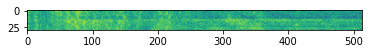

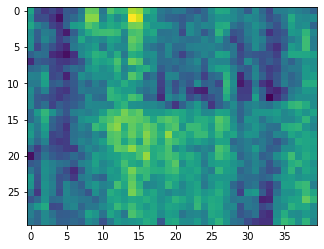

In [3]:
import pyaudio
import wave
import numpy as np
import datetime
RESPEAKER_RATE = 16000
RESPEAKER_CHANNELS = 2
RESPEAKER_WIDTH = 2
# run getDeviceInfo.py to get index
RESPEAKER_INDEX = 0  # refer to input device id
CHUNK = 1024
RECORD_SECONDS = 1 #录音一秒
WAVE_OUTPUT_FILENAME = "./dataset/output_one_channel"


for i in range(0,3*60*60):#录音3h，生成3*3600个wav文件
    p = pyaudio.PyAudio()
    stream = p.open(
                rate=RESPEAKER_RATE,
                format=p.get_format_from_width(RESPEAKER_WIDTH),
                channels=RESPEAKER_CHANNELS,
                input=True,
                input_device_index=RESPEAKER_INDEX,)
    store_path = WAVE_OUTPUT_FILENAME+str(datetime.datetime.now().hour)+str(datetime.datetime.now().minute)+str(datetime.datetime.now().second)+".wav"
    print("* recording:"+store_path)
    a=np.array([])
    frames = [] 
    while(1):
        #读取1秒 16000个点
        for i in range(0, int(RESPEAKER_RATE / CHUNK * RECORD_SECONDS)):
            data = stream.read(CHUNK,exception_on_overflow = False)
            # extract channel 0 data from 2 channels, if you want to extract channel 1, please change to [1::2]
            #a = np.fromstring(data,dtype=np.int16)[0::2]
            a = np.append(a,np.fromstring(data,dtype=np.int16)[0::2])
        print("Wave shape:",a.shape)
        spectrogram = get_spectrogram(a)#信号转频谱
        print("spectrogram shape:",spectrogram.shape)
        melcepstrum = get_melcepstrum(spectrogram)#频谱转梅尔频谱
        print("Model Input melcepstrum shape:",melcepstrum.shape)
        model = tf.keras.models.load_model('./SLA3dPrintAssitant.h5')
        y_pred = np.argmax(model.predict(melcepstrum), axis=1)
        print(y_pred)
        while(1):
            pass
            '''
            melcepstrum = get_melcepstrum(spectrogram)
            model = tf.keras.models.load_model('./SLA3dPrintAssitant.h5')#模型输入 30个时刻,40个梅尔滤波器输出
            y_pred = np.argmax(model.predict(melcepstrum), axis=1)
            print(y_pred)
            '''
    stream.stop_stream()
    stream.close()
    p.terminate()
    wf = wave.open(store_path, 'wb')
    wf.setnchannels(1)
    wf.setsampwidth(p.get_sample_size(p.get_format_from_width(RESPEAKER_WIDTH)))
    wf.setframerate(RESPEAKER_RATE)
    wf.writeframes(b''.join(frames))
    wf.close()
    print("* done recording"+store_path)
    
print("Dataset Recording Finished!")